In [2]:
import cv2 as cv
from keras.preprocessing.image import load_img
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt

# from google.colab import drive
# drive.mount("/content/drive/")

---
#**➡️ Brute Force Matching**
---

## **➜ Brute Force Matching Using SIFT**

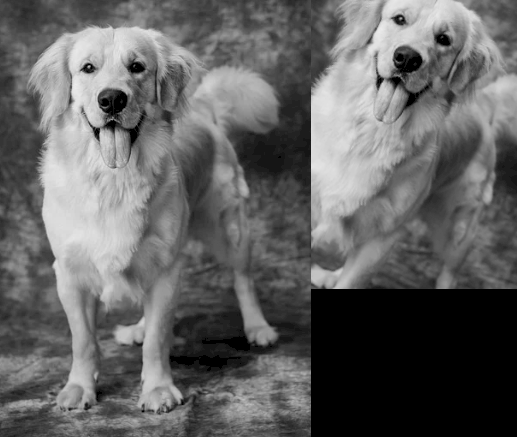

In [16]:
# del img1  # only upon reinitialization
# del img2

sift = cv.SIFT_create()  # initialzes the SIFT detector

img1 = cv.imread('/content/drive/MyDrive/Colab_Notebooks/CV_figs/dog.PNG', 0)  # the first original image
img2 = cv.imread('/content/drive/MyDrive/Colab_Notebooks/CV_figs/dog_crop.PNG', 0)  # the second original image (scaled and rotated variant of img1)

# plot the two original images side by side
cv2_imshow(np.hstack((img1, np.vstack((img2, np.zeros((img1.shape[0]-img2.shape[0], img2.shape[1])))))))

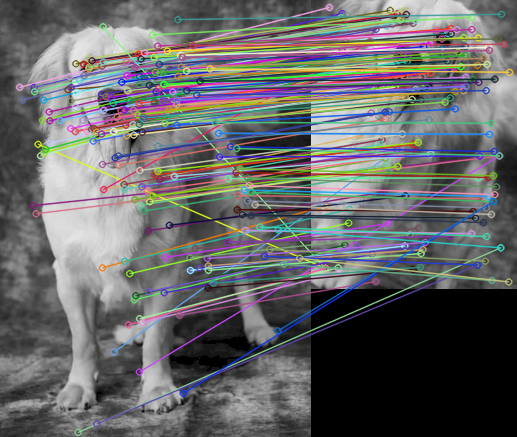

In [17]:
"Find the keypoints and descriptors with SIFT"
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
# display the number of key points: print(len(kp1)) = print(len(des1))
# display the coordinate of a point: print(kp1[0].pt)
# des1 and des2 are computed descriptors, where each descriptor is a 128-element vector. This is a mtrix of size [length(kp1), 128]


"Find matches using k nearest neighbors"
# Brute-force takes the descriptor of one feature in first set (des1) and is matched with all other features in second set (des2) using some distance calculation, and the closest one is returned.
# In this example, it will create len(kp1) matches (finds a match for any descriptor in des1)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)  # returns best two matches in des2 (for any descriptor in des1) in terms of l2-norm
# this means that len(matches) = len(des1)
# to display the two distances to the two best matches of the first descriptor: print(matches[0][0].distance) and print(matches[0][1].distance)
# notice that the the first one is better


"Apply ratio test to threshold the best matches"
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:  # get rid of all mathes that are not that sharp (get rid of discraptors in des1 that similarly match both its the two descriptors in des2)
        good.append([m])
# good is a list od DMatch objects that have with only ONE match and this match is SHARP
img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


# we can see that it succseeded in matching keypoints from the training image (big left one) with kepoints from the query image (small rotated right one)
cv2_imshow(img3)

##**➜ Brure Force Matching with ORB**

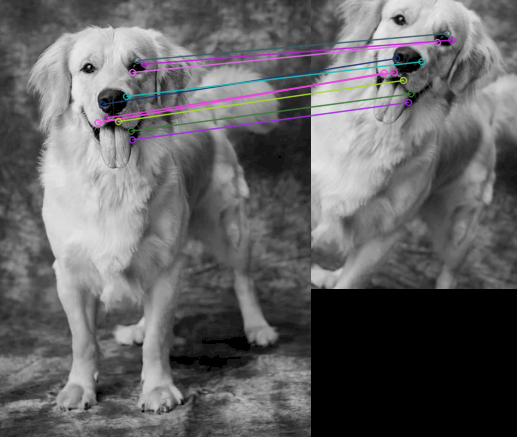

In [18]:
"Find the keypoints and descriptors with ORB"
orb = cv.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)


# Because ORB is a binary descriptor, we find matches using Hamming Distance, which is a measure of the difference between two strings of equal length.
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)  # returns the best match in des2 (for any descriptor in des1) in terms of the Hamming norm
matches = sorted(matches, key=lambda x: x.distance)  # sort them in the order of their distance


# Draw first n matches
n = 10
img3 = cv.drawMatches(img1, kp1, img2, kp2, matches[:n], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,)
cv2_imshow(img3)

---
#➡️ **Learning-based Matching Using LoFTR**
---

In [6]:
!pip install kornia  kornia-rs  kornia_moons opencv-python --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux

In [19]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches

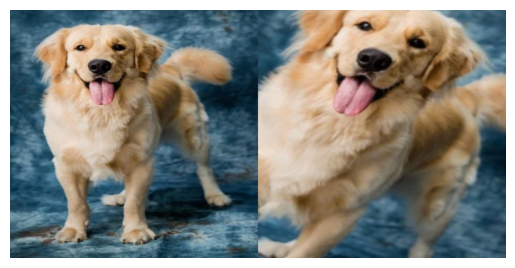

In [61]:
from kornia.feature import LoFTR

img1 = K.io.load_image('/content/drive/MyDrive/Colab_Notebooks/CV_figs/dog.PNG', K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image('/content/drive/MyDrive/Colab_Notebooks/CV_figs/dog_crop.PNG', K.io.ImageLoadType.RGB32)[None, ...]
# the [None, ...] at the end specifies to add another dimension at the beginning of the tensor; this is equivalent to [None, :, :, :], but we might not have the knowledge of hoe many dimensions already exist
# the added dimension is required for LoFTR matcher

# rescale the two images into the same size
img1 = K.geometry.resize(img1, (512, 512), antialias=True)  # antialias=True means that the image will be filtered with Gaussian if downscaling
img2 = K.geometry.resize(img2, (512, 512), antialias=True)


# to display a kornia image (which is a PyTorch tensor), we must convert it into NumPy
# if we want to display the image with its RGB, we discard the new first dimension, and then permute to shape (H,W,3) with 3 RGB chanels at the end
image_np1 = img1[0,:].permute(1,2,0).numpy();  image_np2 = img2[0,:].permute(1,2,0).numpy()

# display the original (scaled) images
plt.imshow(np.hstack((image_np1, image_np2)))
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [77]:
"Module which finds correspondences between two images"
matcher = LoFTR(pretrained="indoor")
# pretrained argument: download and set pretrained weights to the model.
# Options: ‘outdoor’ and ‘indoor’, where ‘outdoor’ is trained on the MegaDepth dataset and ‘indoor’ on the ScanNet.

Downloading: "http://cmp.felk.cvut.cz/~mishkdmy/models/loftr_indoor.ckpt" to /root/.cache/torch/hub/checkpoints/loftr_indoor.ckpt
100%|██████████| 44.2M/44.2M [00:06<00:00, 7.18MB/s]


In [78]:
"Find matching keypoints using a trained LoFTR matcher"
# the LoFTR mathcer only works with grayscale images
input_dict = {"image0": K.color.rgb_to_grayscale(img1), "image1": K.color.rgb_to_grayscale(img2)}
with torch.inference_mode():
    correspondences = matcher(input_dict)

# 'correspondences' is a dictionary containing the coordinates of the keypoints in each image in items "keypoints0" and "keypoints1",
# the confidence score of each match (see the confidence matrix in the document), and batch_indexes of applicable

In [91]:
"Further clean the matching using RANSAC and display the matchings"
mkpts0 = correspondences["keypoints0"].numpy()  # convert the coordinate keypoint tensors into NumPy
mkpts1 = correspondences["keypoints1"].numpy()

# to clear up outlier matches, we take the two sets of keypoints, and estimate their Fundamental Matrix, which is viewd here as a fitting model of the matches
# by applying RANSAC (more specifically, its variant USAC_MAGSAC) for the Fundamental Matrix fitting model, we clean ouliers
# the value 0.5 is the threshold for considering a point to be an inlier
# the value 0.999 is the confidence level that the estimated Fundamental Matrix (fitter) is correct
# the value 100000 is the number of RANSAC iterations
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)

# the 'inliers' set is a numpy array with entries 0=outlier and 1=inlier
inliers = inliers > 0  # converting the 0,1 to False,True as we only want to stay with the indices of the (robust) inliers

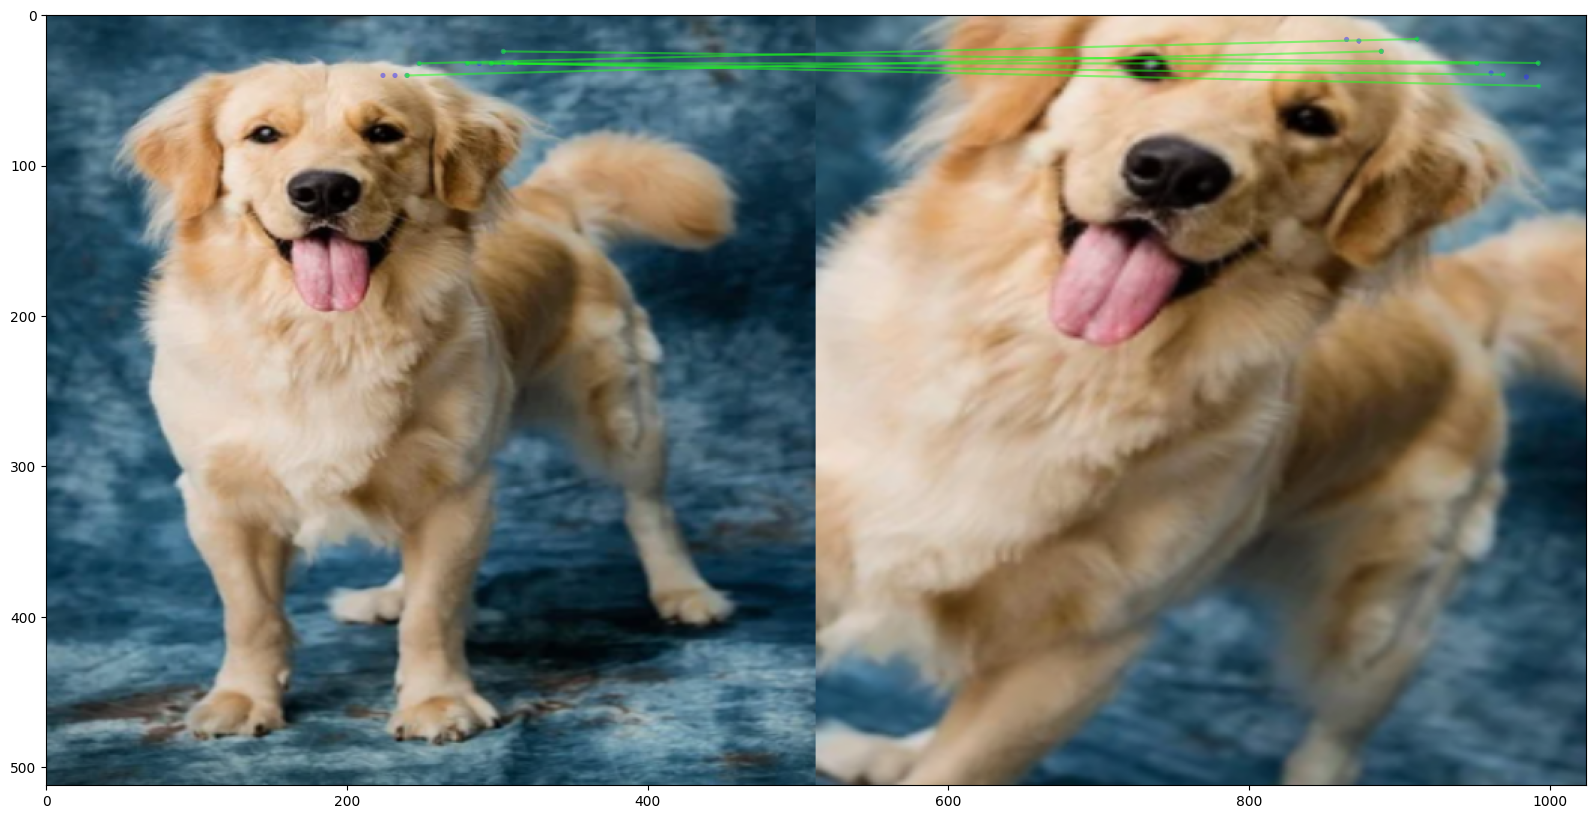

In [102]:
"Dispaly the matches"
num_m = 10  # number of matches to print (for all, set -1)

draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0[0:num_m,:]).view(1, -1, 2),
        torch.ones(mkpts0[0:num_m,:].shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0[0:num_m,:].shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1[0:num_m,:]).view(1, -1, 2),
        torch.ones(mkpts1[0:num_m,:].shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1[0:num_m,:].shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0[0:num_m,:].shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers[0:num_m],
    draw_dict={
        "inlier_color": (0.1, 1, 0.1, 0.5),  # the best matches are visualized in green, while less certain matches are in blue.
        "tentative_color": None,
        "feature_color": (0.2, 0.2, 1, 0.5),
        "vertical": False,
    },
)